In [1]:
import pandas as pd

data = pd.read_csv('Drug_clean.csv')
data.head()

,Condition,Drug,EaseOfUse,Effective,Form,Indication,Price,Reviews,Satisfaction,Type
0,Acute Bacterial Sinusitis,Amoxicillin,3.852353,3.655882,Capsule,On Label,12.590000,86.294118,3.197647,RX
1,Acute Bacterial Sinusitis,Amoxicillin-Pot Clavulanate,3.470000,3.290000,Liquid (Drink),Off Label,287.370000,43.000000,2.590000,RX
2,Acute Bacterial Sinusitis,Amoxicillin-Pot Clavulanate,3.121429,2.962857,Tablet,On Label,70.608571,267.285714,2.248571,RX
3,Acute Bacterial Sinusitis,Ampicillin,2.000000,3.000000,Capsule,On Label,12.590000,1.000000,1.000000,RX
4,Acute Bacterial Sinusitis,Ampicillin,3.250000,3.000000,Tablet,On Label,125.240000,15.000000,3.000000,RX


In [2]:
# Dropping rows where 'Type' or 'Indication' contains '\r\r\n'
data_cleaned = data[~data['Type'].str.contains('\r\r\n') & ~data['Indication'].str.contains('\r\r\n')]

# Display the shape of the original and cleaned data to see how many rows were removed
original_shape = data.shape
cleaned_shape = data_cleaned.shape

original_shape, cleaned_shape

((685, 10), (672, 10))

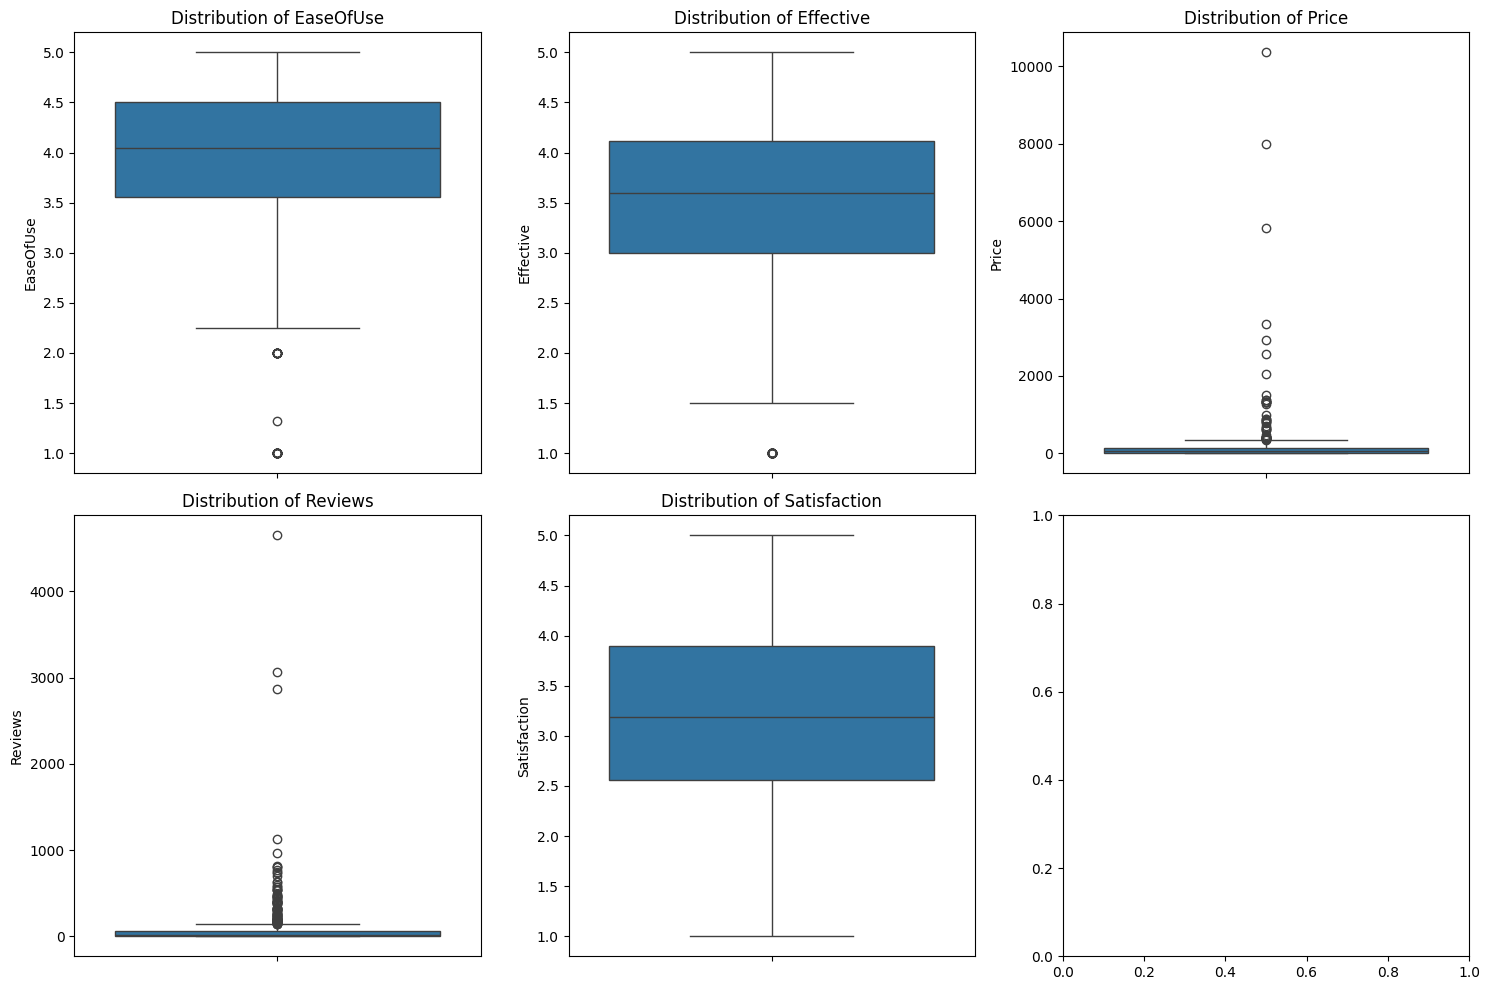

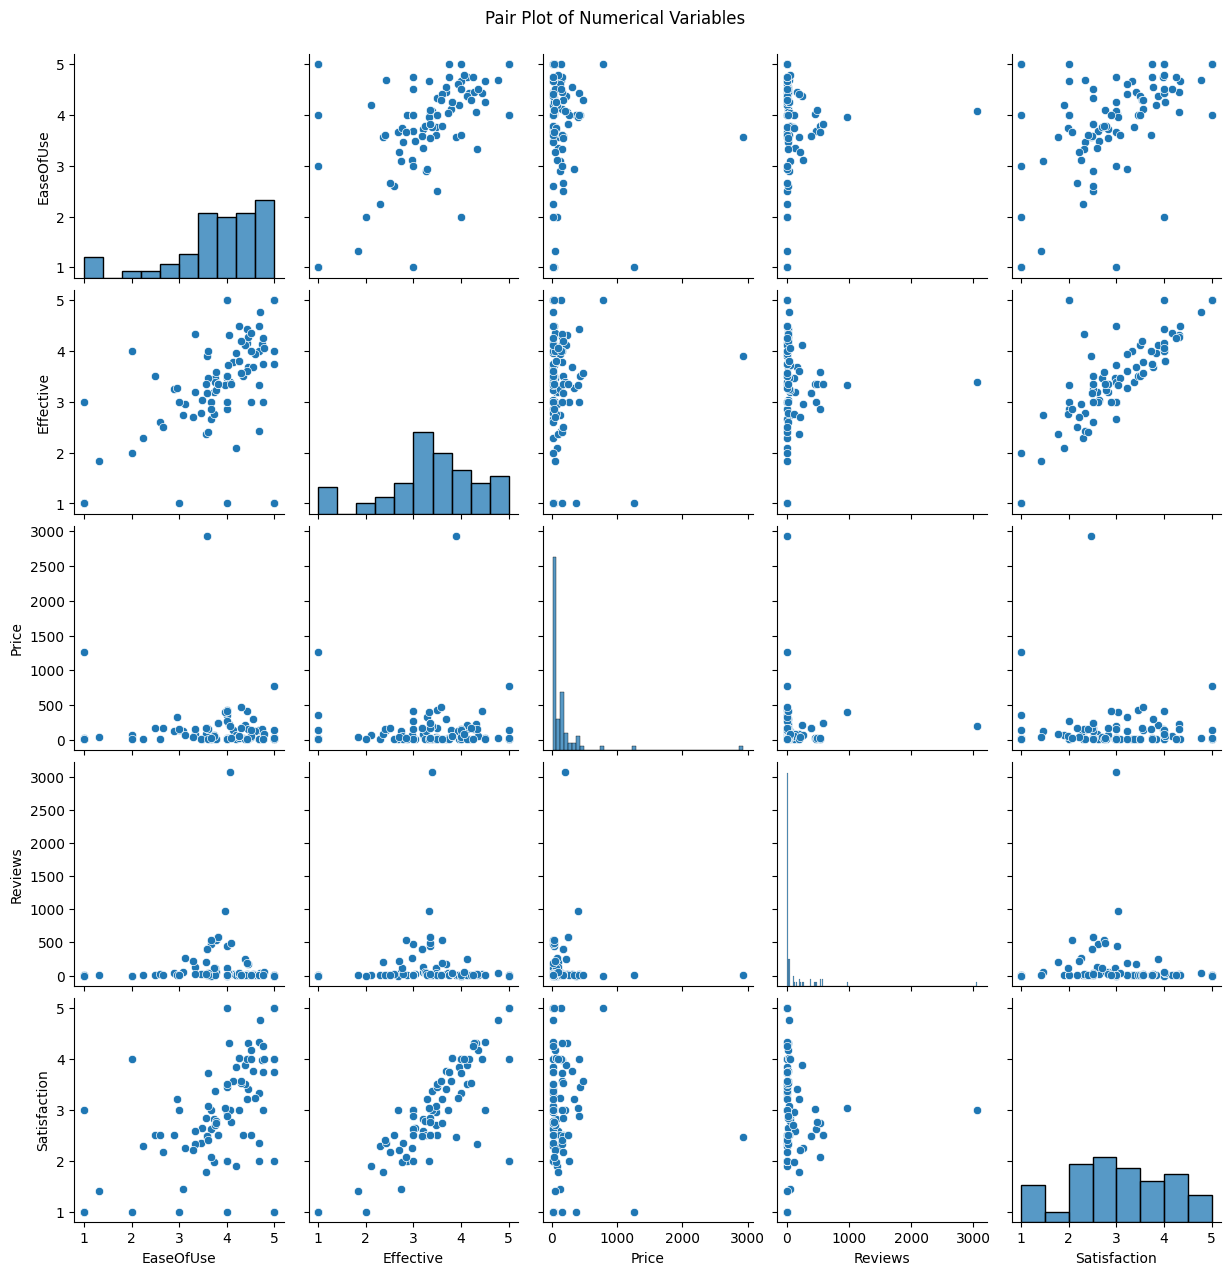

In [7]:
# Generating box plots for numerical variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
numerical_vars = ['EaseOfUse', 'Effective', 'Price', 'Reviews', 'Satisfaction']

for i, var in enumerate(numerical_vars):
    sns.boxplot(ax=axes[i//3, i%3], data=data_cleaned, y=var)
    axes[i//3, i%3].set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()

# Generating a pair plot for a sample of the data to avoid performance issues
sample_data = data_cleaned.sample(n=100, random_state=42)
sns.pairplot(sample_data[numerical_vars])
plt.suptitle('Pair Plot of Numerical Variables', y=1.02) # Adjust title position
plt.show()

In [8]:
from scipy.stats import iqr

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Removing outliers from each numerical variable
data_no_outliers = data_cleaned.copy()
for col in numerical_vars:
    data_no_outliers = remove_outliers(data_no_outliers, col)

# Shape of data before and after outlier removal
original_shape, data_no_outliers.shape

((685, 10), (497, 10))

In [10]:
import statsmodels.api as sm

# Assuming 'Price' is the dependent variable and all other numerical columns are independent variables
X = data_no_outliers[['EaseOfUse', 'Effective', 'Reviews', 'Satisfaction']]
y = data_no_outliers['Price']

# Adding a constant to the independent variables
X = sm.add_constant(X)

# Fitting the OLS model
model = sm.OLS(y, X).fit()

# Printing the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.152
Date:                Tue, 19 Dec 2023   Prob (F-statistic):             0.0142
Time:                        17:00:13   Log-Likelihood:                -2854.3
No. Observations:                 497   AIC:                             5719.
Df Residuals:                     492   BIC:                             5740.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          107.6752     23.199      4.641   

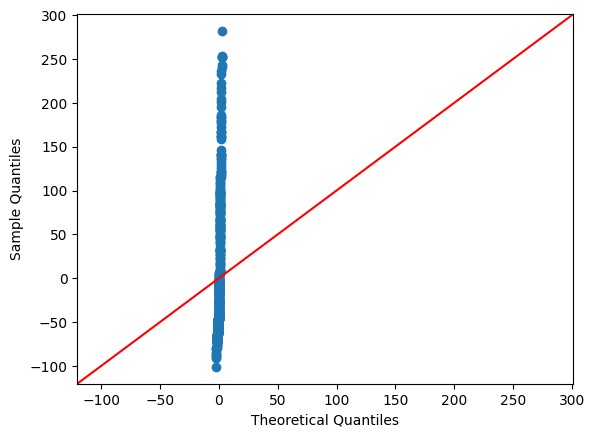

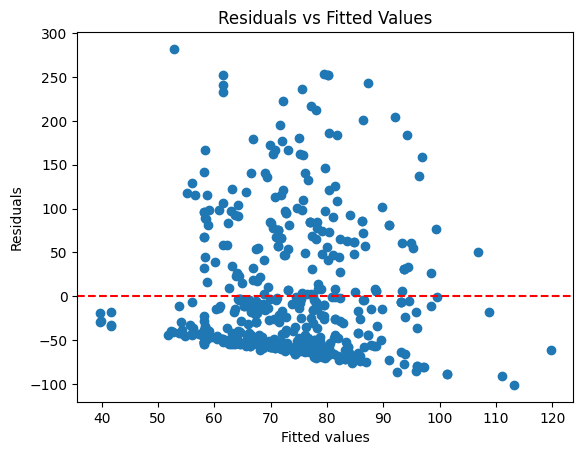

In [11]:
# QQ plot for residuals
sm.qqplot(model.resid, line='45')
plt.show()

# Checking for homoscedasticity
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()

Based on the output of the statsmodels OLS regression and the diagnostic plots, here's a simplified breakdown for step 7, which is recording observations:

### OLS Regression Observations:
- **R-squared**: The R-squared value is 0.025, which suggests that only 2.5% of the variance in the 'Price' is explained by the model. This indicates a weak fit.
- **Adjusted R-squared**: Similarly low, confirming the model does not explain the variation in the target variable well.
- **F-statistic and Prob (F-statistic)**: The F-statistic is low, and the probability suggests the model is not significantly better than an intercept-only model.
- **Coefficients**: 'EaseOfUse' and 'Satisfaction' are statistically significant with p-values less than 0.05. However, 'Effective' and 'Reviews' are not statistically significant in predicting 'Price'.
- **AIC/BIC**: These information criteria are relatively high, indicating that the model may not be the best fit.

### QQ Plot Observations:
- **Distribution of Residuals**: The QQ plot shows that the residuals do not follow a normal distribution, especially in the tails. There are deviations from the line, indicating potential issues with normality.

### Homoscedasticity Observations:
- **Residuals vs. Fitted Values**: The plot of residuals versus fitted values does not display a clear pattern of equal variance across all fitted values. There are some signs of heteroscedasticity as the variance of residuals appears to increase with the fitted values.

### Next Steps:
Given these observations, you may consider the following actions:
1. **Model Improvements**: Since the model does not fit the data well, consider including other variables, interaction terms, or polynomial terms to capture more complexity.
2. **Addressing Normality and Variance**: Transformations, such as a log transformation on the target variable or predictors, may help improve normality and stabilize variance.
3. **Re-evaluation**: After making adjustments to the model, re-evaluate the fit and theed with these steps?

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X is the dataframe of your independent variables
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

        feature        VIF
0         const  46.455879
1     EaseOfUse   1.671139
2     Effective   3.125197
3       Reviews   1.081963
4  Satisfaction   3.150437


In [27]:
# Assuming X and y are already defined and include the constant term
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.152
Date:                Tue, 19 Dec 2023   Prob (F-statistic):             0.0142
Time:                        17:27:36   Log-Likelihood:                -2854.3
No. Observations:                 497   AIC:                             5719.
Df Residuals:                     492   BIC:                             5740.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          107.6752     23.199      4.641   

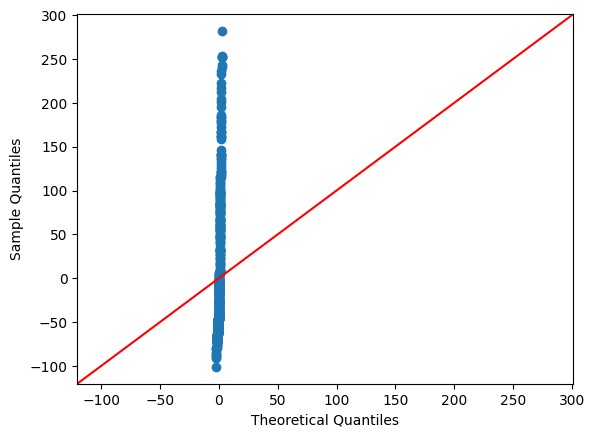

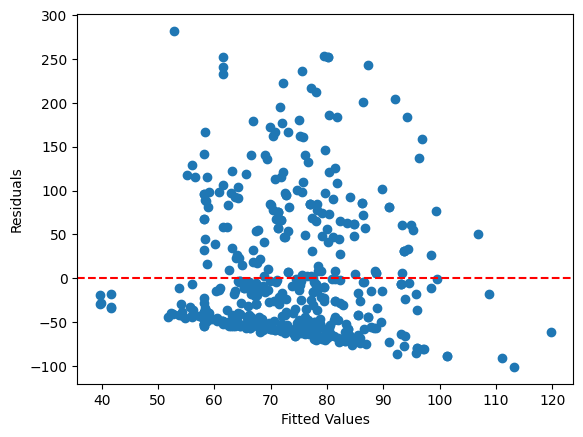

In [28]:
# QQ plot for residuals to check normality
sm.qqplot(model.resid, line='45')
plt.show()

# Scatter plot for residuals to check homoscedasticity
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

In [29]:
import numpy as np

# Log-transform the dependent variable if it's positively skewed
data_no_outliers['Log_Price'] = np.log(data_no_outliers['Price'] + 1)  # Adding 1 to avoid log(0)

# Update the dependent variable in the model
y_log = data_no_outliers['Log_Price']

In [30]:
from sklearn.preprocessing import StandardScaler

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.iloc[:, 1:])  # Assuming X includes the constant term

# Add the constant term back to the scaled variables
X_scaled = sm.add_constant(X_scaled)

In [32]:
# With log transformation
model_log = sm.OLS(y_log, X).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     6.865
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           2.21e-05
Time:                        17:30:18   Log-Likelihood:                -730.22
No. Observations:                 497   AIC:                             1470.
Df Residuals:                     492   BIC:                             1491.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.4294      0.323     13.707   

In [33]:
# With feature scaling
model_scaled = sm.OLS(y, X_scaled).fit()
print(model_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.152
Date:                Tue, 19 Dec 2023   Prob (F-statistic):             0.0142
Time:                        17:30:22   Log-Likelihood:                -2854.3
No. Observations:                 497   AIC:                             5719.
Df Residuals:                     492   BIC:                             5740.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.0950      3.404     21.475      0.0

In [43]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Assuming 'data_no_outliers' is your clean dataset
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(data_no_outliers[['EaseOfUse', 'Satisfaction']])

# Convert to DataFrame and concatenate with original data (excluding the original 'EaseOfUse' and 'Satisfaction' to avoid duplication)
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['EaseOfUse', 'Satisfaction']))
enhanced_df = pd.concat([data_no_outliers.drop(['EaseOfUse', 'Satisfaction'], axis=1), poly_df], axis=1)

# Now 'enhanced_df' has the original data plus the polynomial features
print(enhanced_df.head())

                   Condition                         Drug  Effective  \
0  Acute Bacterial Sinusitis                  Amoxicillin   3.655882   
1  Acute Bacterial Sinusitis  Amoxicillin-Pot Clavulanate   3.290000   
4  Acute Bacterial Sinusitis                   Ampicillin   3.000000   
5  Acute Bacterial Sinusitis            Ampicillin Sodium   3.000000   
7  Acute Bacterial Sinusitis               Clarithromycin   3.458000   

             Form Indication    Price     Reviews Type  Log_Price  EaseOfUse  \
0         Capsule   On Label   12.590   86.294118   RX   2.609334   3.852353   
1  Liquid (Drink)  Off Label  287.370   43.000000   RX   5.664244   3.470000   
4          Tablet   On Label  125.240   15.000000   RX   4.838185   3.582000   
5          Tablet  Off Label  143.215    1.000000   RX   4.971305   2.895000   
7          Tablet   On Label   99.490  141.600000   RX   4.610058   3.600000   

   Satisfaction  EaseOfUse^2  EaseOfUse Satisfaction  Satisfaction^2  
0      3.197647

In [56]:
# Step 1: Ensure that 'enhanced_df' contains only numeric variables
enhanced_df_numeric = enhanced_df.select_dtypes(include=[np.number])

# Step 2: Handle NaN values within 'enhanced_df_numeric'
# Option 1: Drop rows with NaN values
enhanced_df_numeric = enhanced_df_numeric.dropna()

# Option 2: Impute missing values (e.g., with the mean of the column)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# enhanced_df_numeric_imputed = imputer.fit_transform(enhanced_df_numeric)
# enhanced_df_numeric = pd.DataFrame(enhanced_df_numeric_imputed, columns=enhanced_df_numeric.columns)

# Step 3: Separate features and target variable
X_enhanced_numeric = enhanced_df_numeric.drop('Price', axis=1)  # Make sure to remove the target variable
y_enhanced_numeric = enhanced_df_numeric['Price']  # Your target variable

# Step 4: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_enhanced_numeric, y_enhanced_numeric, test_size=0.2, random_state=42)

# Step 5: Train the model
model_enhanced_numeric = LinearRegression()
model_enhanced_numeric.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model_enhanced_numeric.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Output the performance metrics
print(f'R-squared on the test set: {r2}')
print(f'Root Mean Squared Error on the test set: {rmse}')


R-squared on the test set: 0.7916358917587035
Root Mean Squared Error on the test set: 28.77278301454501


In [58]:
from sklearn.metrics import r2_score, mean_squared_error

# Predict on training data
y_train_pred = model_enhanced_numeric.predict(X_train)

# Calculate metrics for training data
r2_train = r2_score(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Output the performance metrics for training data
print(f'R-squared on the training set: {r2_train}')
print(f'Root Mean Squared Error on the training set: {rmse_train}')

# You've already calculated these for the testing data, but let's print them again for comparison
print(f'R-squared on the test set: {r2}')
print(f'Root Mean Squared Error on the test set: {rmse}')

# Perform cross-validation
from sklearn.model_selection import cross_val_score

# Use negative mean squared error for cross-validation scoring; it returns negative values for easier maximization
cv_r2_scores = cross_val_score(model_enhanced_numeric, X_enhanced_numeric, y_enhanced_numeric, cv=5, scoring='r2')
cv_rmse_scores = cross_val_score(model_enhanced_numeric, X_enhanced_numeric, y_enhanced_numeric, cv=5, scoring='neg_root_mean_squared_error')

# Print the average R-squared and RMSE across all folds
print(f'Average R-squared from cross-validation: {cv_r2_scores.mean()}')
print(f'Average RMSE from cross-validation: {-cv_rmse_scores.mean()}')


R-squared on the training set: 0.8490865903490783
Root Mean Squared Error on the training set: 32.08582412107167
R-squared on the test set: 0.7916358917587035
Root Mean Squared Error on the test set: 28.77278301454501
Average R-squared from cross-validation: 0.8114998079809634
Average RMSE from cross-validation: 32.70921883403579
